# Word2Vec Model Training, Perfomance Evaluation and Exploration

**Description:** In this Jupyter notebook, we train a Word2Vec model of text data using Gensim.  Word2Vec models words in a text dataset as numeric vectors. For a review of Word2Vec check out this [blog post](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/). We also include code in this notebook to evaluate model quality on the Google Analogy Test on any trained Word2Vec model, and explore any trained Word2Vec model.

**Table of Contents**

* Part 1: [Train a Word2Vec model on some text data](#Train)
* Part 2: [Explore and visualize your Word2Vec model](#Results)
* Part 3: [Test your model's quality using the Google Analogy Test](#Accuracy)

Import external functions and packages

In [1]:
import cython #ENSURE cython package is installed on computer/canopy
from gensim.models import phrases 
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from statistics import mean
from gensim.models import Word2Vec, KeyedVectors
import pandas as pd
from string import ascii_letters, digits
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.test.utils import datapath
#np.set_printoptions(threshold=np.inf) #set to print full output

#if you don't have any of these libraries, you will need to install them first with conda install or pip install

<a id='Train'></a> 
## Part 1: Train a Word2Vec Model, Explore Hyperparameters

## We will be using the Abortion Privacy Tweets Dataset
### If you prefer to use another dataset, feel free to, if you need one - you can download that here:
Gensim has a few free suggestions, such as the [Text8 Corpus](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Text8Corpus)
    
Or, download this free Kaggle dataset of 3 million news headlines from the [Examiner](https://www.kaggle.com/therohk/examine-the-examiner/version/3)  and restructure for Word2Vec using code below.

Note that in the paper, we train our model around 100,000 New York Times articles on obesity and health, published between 1980-2016. We provide details to get and explore our trained model in Part 2. 

In [6]:
dat = pd.read_json('/home/karl/PycharmProjects/UCSF_dobbs_roe/data/from_2020_01_01/dobbs.json', lines=True)
dat = dat['rawContent']
dat #view what it looks like

0         Red States | Stacey Abrams | Kari Lake | Crist...
1         @cmcbrien Even more tough. Need the paddle to ...
2         Voter registrations in Kansas City are up by o...
3         @JuliaDavisNews @YouTube Crazy. Perhaps you sh...
4         The Patriots invested a 4th round pick in a ba...
                                ...                        
648738    @NunesDrag @DevinCow Lou Dobbs deserves a 50 g...
648739    @NunesDrag @DevinCow Lou Dobbs, for his attemp...
648740    @NunesDrag @DevinCow McCarthy is retiring peop...
648741             @LouDobbs #Dobbs https://t.co/mL0iU1BSp6
648742    @realDonaldTrump Lou dobbs is always right big...
Name: rawContent, Length: 648743, dtype: object

*Preprocessing and Cleaning* 

From visually looking at the data, it is already pretty clean. Most importantly, letters are all lowercased, and punctuation removed. But we'll need to remove digits. And, the corpus needs to be re-structured for Word2Vec into a list of "sentences" or, in this case, headlines. Within each "sentence" we'll tokenize the string such that each word is a token.

*Fake original text data, before being cleaned and pre-processed might have looked something like this:*

    mydata= [These are words in the First sentence. These are words in the Second sentence! These are words in the Third sentence.] 
    
*We want to clean it to be an object like this:*

    sentences= [['these', 'are', 'words', 'in', 'the', 'first', 'sentence'], ['these', 'are', 'words', 'in', 'the' , 'second', sentence], [these, 'are', 'words', 'in', 'the' , 'third', 'sentence']]


Pre-processing in natural language processing commonly include removing stop words (words that are frequent but considered meaningless by some researchers, such as "the") and stemming words (e.g., reducing all words to a single tense, like "running and "runs" to "run"). We do not remove stop words, which we consider meaningful, and Word2Vec well equipped to extract any meaning from stop words if it is there (i.e., if a stopword predicts other words' meaning), or to place little emphasis on stop words (or noise) if they do not predict other words' meaning. We also do not stem words. On smaller datasets stemming can be a strategy to reduce the vocabulary size and increase the number of instances of each vocabulary word, but the vocabulary size of the data set we initially trained on (New York Times articles) was a large corpus, and so we can use unstemmed words.

In [12]:
dat.values
dat2 = [str(i) for i in dat.values] #only need the text of each headline in the 1st index, not the date, in the 0th index
dat2

['Red States | Stacey Abrams | Kari Lake | Crist\nChristie | Misinformation | My 401k | Fentanyl | Arrest\n Dana Bash | Dobbs Shameless #MorningJoe Woke War III https://t.co/T54b6yHNIs',
 '@cmcbrien Even more tough. Need the paddle to do the old 2 button knuckle rub. Me and my buddies use to put bandaids on our fingers to help. 😅',
 'Voter registrations in Kansas City are up by over 35% in the time since the Dobbs abortion ruling, compared to the same period four years ago.\n\nAnd at least in Kansas, those new registrants are disproportionately women. My latest with @drdesrochers: https://t.co/vtJtbYg7b5',
 "@JuliaDavisNews @YouTube Crazy. Perhaps you should find some other way of sharing them.  Important to know what these people are saying. That's why we had foreign language monitoring services during WWII and Cold War...",
 "The Patriots invested a 4th round pick in a backup QB who tore the #Browns apart this week.  They weren't afraid to develop a back up...why are the Browns?  \n\

In [13]:
translator = str.maketrans(ascii_letters, ascii_letters, digits) #stripping digits here, see: https://stackoverflow.com/questions/32538305/using-translate-on-a-string-to-strip-digits-python-3

sentences=[]
for i in dat2:
    headline= i.translate(translator)
    headline= headline.strip()
    sentences.append(headline.split())
    
print(sentences[1])
print(len(sentences)) # check that it is actually around 3 million headlines here as supposed to be. its ok if not perfectly clean (i.e.  some words that are nonsensical) for these purposes

['@cmcbrien', 'Even', 'more', 'tough.', 'Need', 'the', 'paddle', 'to', 'do', 'the', 'old', 'button', 'knuckle', 'rub.', 'Me', 'and', 'my', 'buddies', 'use', 'to', 'put', 'bandaids', 'on', 'our', 'fingers', 'to', 'help.', '😅']
648743


In [14]:
#does sentences look ok? then delete dat and dat2 to save up some space
del(dat2)
del(dat)

#### Next, we'll train a Word2Vec model on our sentences object. Here are some hyperparameters involved:

* For a review see [Rong 2014](https://arxiv.org/abs/1411.2738)  and the [Gensim documentation](https://radimrehurek.com/gensim/models/word2vec.html)

Key hyperparameters for Word2Vec include the learning architecture (Skip Gram or Context Bag of Words), the dimensionality of the word-vectors we will learn, and the context window of words, "window". Skip-gram sets up the artificial neural network underlying Word2Vec to predict set of context words given a target word. CBOW, or Context Bag of Words, sets up the network to predict a target word given a set of context words. The number of context words used is set by the "window" parameter. 

* size = word vector dimensionality. This usually ranges between 50-500 with gains in model performance diminishing after 300 (Mikolov et al. 2013a). We've seen up to 1000, but usually see 100, 300, and sometimes 500 dimensions on larger corprora. If you have a smaller dataset, stick to smaller dimensionality, roughly 50-200. Even 100 dimensions is a lot to learn! And, if you are using the embeddings for a classifiation task down the road (like in Part C of this GitHub Repo), it might be better to keep dimensionality low. 
* min_count = minimum word count. Any word that does not occur at least this many times across all documents is ignored. Default is 5. I often set this higher to learn only high quality word-vectors. 
* workers = number of threads to run in parallel, we set to 4. This speeds up training a lot, but to use make sure Cython is installed first. 
* window = context window size. This is the numebr of words used to predict a target word (in CBOW) or to be predicted from a target word (SG). A larger window captures topical similarity, smaller captures is semantic similarity (Goldberg 2016, Levy and Goldberg 2014).
* seed= can set a seed for reproducibility, note you also cannot use multiple workers for a fully reproducible model.
* sg = learning architecture: skip-gram (1) or CBOW (0). Skip-gram sets up the artificial neural network underlying Word2Vec to predict set of context words given a target word. CBOW, or Context Bag of Words, sets up the network to predict a target word given a set of context words. 
* hs= training algorithm to speed up computations: hierarchical softmax (1) or negative sampling (0)
    

#### Train Models with Combos of Hyperparameters

Try a few combos of hyperparameters and see which performs best on your dataset by evaluating their accuracy in Part 2. 

Run bigram transformer, below. This allows our vocabulary to include not just single words but also bigrams (two-word phrases, like "New York"). This transformation needs to be done before training the Word2Vec model. 

Notes for your own implementation:
* You can run one time to catch two-word phrases, like "New_York", or two times times, such as to catch three-word phrases (like "New_York_City"), or more times. For more information see the [Gensim documentaion.](https://radimrehurek.com/gensim/models/phrases.html).
* If you only want single word-tokens, then just use "sentences" when you feed into Word2Vec() rather than feeding in bigram_transformer[sentences] 

In [15]:
#your "sentences" object with the cleaned text data. 
bigram_transformer = phrases.Phrases(sentences) 
bigram = phrases.Phraser(bigram_transformer)

Try training various models which vary by learning architecture (Skip Gram vs Context Bag of Words).

In [17]:
currentmodel = Word2Vec(sentences, workers=44, sg=0, vector_size=100, min_count=5, window=5, sample=1e-3)

Save your model to your working directory

In [18]:
currentmodel.init_sims(replace=True) #Precompute L2-normalized vectors. If replace is set to TRUE, forget the original vectors and only keep the normalized ones. Saves lots of memory, but can't continue to train the model.

/tmp/ipykernel_449630/4267094580.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  currentmodel.init_sims(replace=True) #Precompute L2-normalized vectors. If replace is set to TRUE, forget the original vectors and only keep the normalized ones. Saves lots of memory, but can't continue to train the model.


In [19]:
currentmodel.save("dobbs_test_model") #save model for later use! change the name to something to remember the hyperparameters you trained it with

In [20]:
currentmodel = Word2Vec.load("dobbs_test_model") # if you exited jupyter can reload model with this

In [22]:
currentmodel.wv['the'] #look at the raw word-vector for "the"

array([ 0.11464207, -0.15948045, -0.02733234,  0.13369378, -0.05097222,
        0.00293358,  0.05137463, -0.08696754,  0.05330345,  0.08597347,
        0.20745692,  0.04631235,  0.1406089 ,  0.10667442, -0.03691275,
        0.06507011, -0.04273833, -0.07578032, -0.08951113,  0.04493287,
        0.04223906, -0.07451785, -0.03272229,  0.0295373 , -0.05923457,
        0.08002572,  0.00906783,  0.05952178,  0.02751056,  0.00744249,
       -0.18886861,  0.0728671 ,  0.1472141 ,  0.02090785, -0.00168513,
       -0.05225476,  0.12652858, -0.14487956,  0.00956897,  0.3039122 ,
       -0.17114991,  0.17580396, -0.01574024, -0.0514705 , -0.03298126,
        0.16344714,  0.10798585, -0.08491304,  0.09618659, -0.05065196,
       -0.05325283,  0.01190161,  0.1121569 ,  0.12180283,  0.10683677,
       -0.1650926 ,  0.02324435,  0.07702729,  0.04003301, -0.03585785,
       -0.05126716,  0.03650659, -0.08064969,  0.02991757,  0.03486582,
       -0.09509482, -0.05597068,  0.07299868,  0.15250996, -0.06

<a id='Results'></a> 
## Part 2: Explore and Visualize your Word2Vec Model

If you're jumping right to here and didn't go though Part 1, look at last few lines of [Part 1](#Train) for help to upload your own trained model or a pre-trained model you want to explore. 

How many vocabulary words were learned by the model? 

In [24]:
len(currentmodel.wv.index_to_key)

112337

Let's look at the raw word-vector for 'woman'. These numbers aren't so meaningful to human readers on their own. 

In [25]:
currentmodel.wv['privacy']

array([-0.01988416, -0.12110896, -0.10628793, -0.04758658,  0.01818191,
       -0.12593734,  0.02302902, -0.07539114, -0.09859637, -0.10925049,
       -0.02587677, -0.09924772,  0.08275457,  0.01327879, -0.06645536,
        0.13382824, -0.04536648,  0.04987371, -0.01487918, -0.08272064,
       -0.04636189, -0.12169039,  0.05550968,  0.15577206, -0.22759072,
        0.08499565, -0.03808505, -0.00106909, -0.1197793 ,  0.05742358,
       -0.14187229,  0.05268376,  0.01173006,  0.15079816, -0.1347983 ,
        0.00966141,  0.10614919, -0.01142282, -0.01732504,  0.09756015,
       -0.1263412 ,  0.01606396, -0.00082408, -0.14535256, -0.06953715,
        0.10253876,  0.08600886,  0.03209823,  0.01369889, -0.04297224,
       -0.02435747,  0.04836946,  0.04350801,  0.13076437,  0.211608  ,
       -0.01522933,  0.0176598 ,  0.01420165, -0.24740556, -0.01158717,
        0.14845258,  0.1944483 ,  0.08338939,  0.1001213 ,  0.03645708,
        0.2216933 , -0.12810954, -0.12171233, -0.05011886, -0.16

What are the most similar words to "privacy"? What are the cosine simiarlties?

* Cosine Similarity ranges 0-1 here, with 0 corresponding to two words that share NOTHING in common, and 1 suggesting they are the exact same meaning. For a review on cosine similarity for word-vector models, see this [article](http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/). 
* Surprised that a word like "man" is so similar to "woman"? While these two are opposites in terms of gender, otherwise they correpond to largely the same meaning (adults, humans, singular, nouns, etc.), so they should be very similar and close in space. 

In [26]:
currentmodel.wv.most_similar('privacy', topn=10)

[('privacy,', 0.7720276117324829),
 ('constitutional', 0.7669219970703125),
 ('fundamental', 0.7331950068473816),
 ('privacy.', 0.6999197602272034),
 ('contraception', 0.6863921880722046),
 ('Constitutional', 0.6856572031974792),
 ('unenumerated', 0.6732276082038879),
 ('liberty', 0.6649438142776489),
 ('“liberty”', 0.6529538631439209),
 ('statutory', 0.6528445482254028)]

Calculate cosine similarity of two words specifically

In [27]:
print(1 - spatial.distance.cosine(currentmodel.wv['privacy'], currentmodel.wv['doctor']))

0.27414390444755554


Which words are FARTHEST from big? Doesn't work so well, results aren't usually meaningful. This shows how distance as can break down as a meaningful measure in this model compared to our intuitions.  

In [28]:
currentmodel.wv.most_similar(negative=['privacy'])

[('Holy', 0.4087540805339813),
 ('Old', 0.4049072265625),
 ('Collins’', 0.3993227183818817),
 ('Man,', 0.3925321698188782),
 ('Stenstrom', 0.3915293514728546),
 ('.)', 0.38786178827285767),
 ('@mazemoore', 0.3728673756122589),
 ('(Republican)', 0.36938565969467163),
 ('Diehard', 0.3680065870285034),
 ('@WhiskeyMD', 0.36785888671875)]

Let's try some tricks:

Let's ask our model to solve the anaology, man is to king as woman is to ? 

Specifically, we ask the model to find the word-vector that is most similar to the vector leftover from the vector algebra: king + woman - man

Another way to think about our expected relationship is:
* A queen is a *feminine* king. 
* If we take *woman* and subtract *man*, we get just the parts that about being feminine, since we subtracted out parts that are shared between men and woman (e.g., being a human, adult, noun, singular, etc.). 
* If we take away the masculinity from king (subtract man), and add the femininity (add woman), we get the feminine version of a king- a queen! 

If you're model doesn't solve this correctly, try a few other tricks to see if it gets those.

In [36]:
print(currentmodel.wv.most_similar(positive=['woman', 'king'], negative=['man'])) #man:king as woman:_?___ QUEEN!

[('embodiment', 0.5994127988815308), ('symbol', 0.5898528695106506), ('epitome', 0.587098240852356), ('contents', 0.5843690633773804), ('mother,', 0.5662814378738403), ('characterization', 0.5608870983123779), ('"Church', 0.5594337582588196), ('fraction', 0.5531642436981201), ('universe,', 0.5465182662010193), ('definition', 0.5464732646942139)]


Try another analogy: boy is to man as girl is to? 

In [33]:
print(currentmodel.wv.most_similar(positive=['girl', 'man'], negative=['woman'])) #boy:man as girl:_?___ WOMAN!

[('citation', 0.5990646481513977), ('bioethics', 0.5838362574577332), ('Disclosures', 0.5776018500328064), ('selectively', 0.5688239336013794), ('Declaration', 0.56840980052948), ('writings', 0.5660301446914673), ('privacy,', 0.5611934661865234), ('freedom."', 0.559859037399292), ('deprivation', 0.5573384761810303), ('HIPAA', 0.5567502379417419)]


A trickier trick! Can Word2Vec which word doesn't match? It should be able to tell based on which word has the lowest cosine similarity to all the other words. 

In [31]:
currentmodel.wv.doesnt_match("noodle chicken turkey beef".split()) #does it get that noodle is not a meat?

C:\Users\Alina Arseniev\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
C:\Users\Alina Arseniev\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:876: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'noodle'

In [32]:
currentmodel.wv.doesnt_match("tomato potato toe".split()) #does it get that a toe is not a fruit or veggie?

C:\Users\Alina Arseniev\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


'toe'

Let's look at the most "feminine" and "masculine" words

* Previously we asked Word2Vec to solve the analogy of king and queen; now we're going to isolate gendered meaning. 
* If we take woman and subtract man, we get just the parts that about being feminine, since we subtracted out parts that are shared between men and woman (e.g., being a human, adult, noun, singular, etc.). Now we're asking what are the most similar words to this leftover vector, that represents femininity?
* We can quickly do this in the below lind which looks ath the most similar words to +woman, -man (i.e, woman-man).



In [34]:
print(currentmodel.wv.most_similar(positive=['woman'], negative=['man'], topn=10)) #what are the most feminine words?

[("States'", 0.5268466472625732), ("states'", 0.5131288766860962), ('unenumerated', 0.5091561675071716), ('usurping', 0.4996320307254791), ('nondiscrimination,', 0.4874122142791748), ('privacy,', 0.48041975498199463), ('privacy)', 0.4798688590526581), ('Miranda', 0.46987679600715637), ('restoring', 0.4625738263130188), ('Fundamental', 0.4602386951446533)]


In [35]:
print(currentmodel.wv.most_similar(positive=['man'], negative=['woman'], topn=10)) #what are the most masculine words?

[('privacy,', 0.4504343569278717), ('privacy.', 0.44782111048698425), ('Bodily', 0.40504539012908936), ('privacy?', 0.40389883518218994), ('(Casey)', 0.4028555154800415), ('persons"', 0.39700740575790405), ('tradition,', 0.3955317735671997), ('autonomy."', 0.38552746176719666), ('autonomy,', 0.38454747200012207), ('privacy"', 0.3819960355758667)]


In [39]:
#gendervec= 

In [53]:
gendervec = currentmodel['woman'] - currentmodel['man']
myinterestingword= currentmodel['guy'].reshape(1,-1)
howgenderedscalar = cosine_similarity(gendervec.reshape(1,-1), myinterestingword) #th

#gendervec.reshape(1,-1)[0]

In [54]:
howgenderedscalar 

array([[-0.23258102]], dtype=float32)

**Visualize Word-Vector Neighborhoods**

Try visualizing a set of words:

In [33]:
#review of tsne: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
#modified code from https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne/code

#define a function to visualize word-vectors in 2-D version of the high dimensional space

def tsne_plot(words, vectors, iterations, seed, title): 
    "Creates and TSNE model and plots it"
    tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=iterations, random_state=seed) #you may need to tune these, epsecially the perplexity. #Use PCA to reduce dimensionality to 2-D, an "X" and a "Y 
    new_values = tsne_model.fit_transform(vectors)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(words[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.ylabel("Latent Dimension 1") #Some pyplot reminders: https://matplotlib.org/users/pyplot_tutorial.html
    plt.xlabel("Latent Dimension 2")
    plt.title(title)
    plt.show()

In [34]:
my_word_list=[]
my_word_vectors=[]
label=[]

words_to_explore= ['woman', 'man', 'queen', 'king', 'human', 'person', 'girl', 'child', 'boy', 'salad', 'lettuce', 'tomato', 'soup', 'turnip', 'arugula', 'pepper', 'greens', 'barley', 'bean', 'stew', 'carrot']

for i in words_to_explore:   
    try:
        if my_word_list not in my_word_list:
            my_word_vectors.append(currentmodel.wv[i])
            my_word_list.append(i)
    except KeyError: #if one of the words_to_explore is not in the model vocab, just skip it
        continue

C:\Users\Alina Arseniev\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


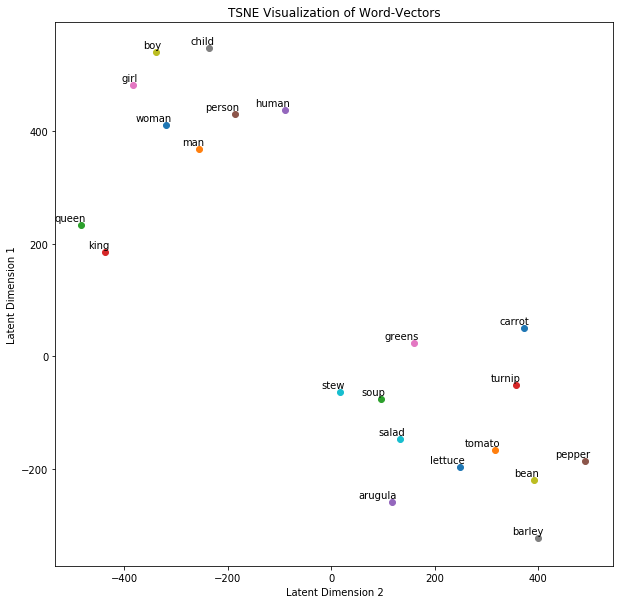

In [35]:
tsne_plot(my_word_list, my_word_vectors, 3000, 23,  "TSNE Visualization of Word-Vectors") #don't use too many words, won't finish running

Try visualizing the most feminine and most masculine words:

In [21]:
my_word_list=[]
my_word_vectors=[]
label=[]

for i in currentmodel.wv.most_similar(positive=['woman'], negative=['man'], topn=30):   #30 most feminine words
    if my_word_list not in my_word_list:
        my_word_list.append(i[0])
        my_word_vectors.append(currentmodel.wv[i[0]])
        label.append('fem')

for i in currentmodel.wv.most_similar(positive=['man'], negative=['woman'], topn=30):   #30 most masculine words
    if my_word_list not in my_word_list:
        my_word_list.append(i[0])
        my_word_vectors.append(currentmodel.wv[i[0]])
        label.append('masc')

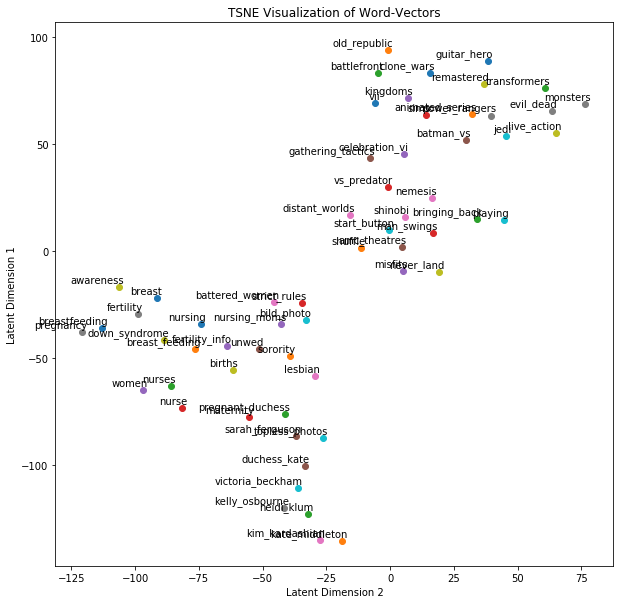

In [22]:
tsne_plot(my_word_list, my_word_vectors, 3000, 23,  "TSNE Visualization of Word-Vectors") #don't use too many words, won't finish running

If your plot doesn't look meaningful, want to see how robust the patterns are, or you want to understand TSNE better, try tuning parameters (especially the perplexity) and take a look at this great [article](https://distill.pub/2016/misread-tsne/).

<a id='Accuracy'></a> 
## Part 3: Word2Vec Model Accuracy

The **Google Analogy Test** is one of the most accepted strategies to evaluate how "good" or high quality your model is. The Google Analogy Test includes a series of analogies divided up into subsections, including world capitals, countries’ currencies, family, and a series of syntactic sections such as tense and plurality.  For example, an analogy in the semantic section of World Capitals will include: “Berlin: Germany as Paris: ?” and if the model responds correctly it will return: “France.” An analogy in the semantic section of family will include: “Mother: Father as Daughter: Son.” In the syntax section with tense, a sample analogy might be “Walk: Walked as Run: Ran.”  The Google Analogy test includes approximately 20,000 questions, and accuracy is the proportion of these questions that the model answers correctly. A "better" model should answer more questions correctly. As we'll see, this isn't the best measure but it is a good starting point. 

**Now let's look at the model accuracy on the Google Analogy Test:**

In [9]:
#Make sure you have downloaded these files into your working directory from this from the Github repo https://github.com/arsena-k/Word2Vec-bias-extraction: questions_words_pasted.txt, testing.py, and question-words.txt

accuracy=currentmodel.wv.accuracy('questions_words_pasted.txt') 

accuracy_labels= [accuracy[i]['section'] for i in range(0, len(accuracy))]
accuracy_tracker=[]
for i in range(0, 15):
    sum_corr = len(accuracy[i]['correct'])
    sum_incorr = len(accuracy[i]['incorrect'])
    total = sum_corr + sum_incorr
    print("Accuracy on " + str(accuracy_labels[i]) + ": "  + str(float(sum_corr)/(total)))
    accuracy_tracker.append(float(sum_corr)/(total))

print('\033[1m' + "Average Accuracy On a Section: " + str(mean(accuracy_tracker[0:-1])) + '\033[0m')

C:\Users\Alina Arseniev\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `accuracy` (Method will be removed in 4.0.0, use self.evaluate_word_analogies() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy on capital-common-countries: 0.15
Accuracy on capital-world: 0.10599078341013825
Accuracy on currency: 0.0
Accuracy on city-in-state: 0.09783513738551207
Accuracy on family: 0.7026315789473684
Accuracy on gram1-adjective-to-adverb: 0.04411764705882353
Accuracy on gram2-opposite: 0.0641025641025641
Accuracy on gram3-comparative: 0.41748768472906406
Accuracy on gram4-superlative: 0.37384615384615383
Accuracy on gram5-present-participle: 0.5042735042735043
Accuracy on gram6-nationality-adjective: 0.2016509433962264
Accuracy on gram7-past-tense: 0.20114942528735633
Accuracy on gram8-plural: 0.35700757575757575
Accuracy on gram9-plural-verbs: 0.44047619047619047
Accuracy on total: 0.2745495255357714
Average Accuracy On a Section: 0.26146922776217696


*Notes on the Google Analogy Test:*

When originally published, Word2Vec averaged at around 60% across all sections of the Google Analogy Test. Models I've trained on a large news corpus tend to average between 50 and 60%. On smaller coropora, or more heterogenous corpora, accuracy rates might even hover around 0. The Google Analogy test is a useful benchmark, but may be more or less meaningful on different datasets. For example, we might not expect it provide useful infomration on a historical dataset, which contains different language and knoweldge (e.g., some currencies and capitals were likely different at the time the data was produced). For some datasets, it may be useful to select certain sections that are more meaningful than others, such as dropping the section on money for a data set on narratives. 

Even with low performance on this test, vectors might still contain meaningful, interesting information, but might not be robust or high quality enough for more complex tasks. You can also try tweaking the hyperparameters used to improve performance, especially the dimensionality, context window, and learning architecture. 

**Another Way to Evaluate Model Quality** is to compare human-rated similarities between words, with cosine-similarities based on Word2Vec. 
The below code illustrates how to compute this, using a standard dataset for human-rated similarities called "wordsim353".

In [13]:
similarities = currentmodel.wv.evaluate_word_pairs(datapath('wordsim353.tsv'))
similarities

C:\Users\Alina Arseniev\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


((0.6238773423318839, 1.7963265731961865e-39),
 SpearmanrResult(correlation=0.6589215888009288, pvalue=2.5346056459149263e-45),
 0.0)